# Graph GP Regression
## Preamble
This notebook provides an example of Gaussian process regression on a graph using Graph Matern kernel.

In [ ]:
import networkx as nx
import numpy as np
import pickle
import gpflow
import os
import warn
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import trange
from scipy import sparse

from utils.preprocessing import load_PEMS
from utils.plotting import plot_PEMS

from graph_matern.kernels.graph_matern_kernel import GraphMaternKernel
from graph_matern.kernels.graph_diffusion_kernel import GraphDiffusionKernel

In [3]:
dtype = tf.float64
gpflow.config.set_default_float(dtype)
gpflow.config.set_default_summary_fmt("notebook")

In [4]:
np.random.seed(1111)
num_eigenpairs = 500
dataset = 'PeMS-Bay-new'
num_train = 250

## Load and preprocess the PEMS dataset
The nasty details of the dataset preparation are hidden away in `preprocessing` module.

In [5]:
G, data_train, data_test, data = load_PEMS(num_train=num_train)

x_train, y_train = data_train
x_test, y_test = data_test
x, y = data

orig_mean, orig_std = np.mean(y_train), np.std(y_train)
y_train = (y_train-orig_mean)/orig_std
y_test = (y_test-orig_mean)/orig_std

epsg:4326


##  Compute Laplacian eigenpairs

In [6]:
# Save/load the eigenpairs to save up some computational time
eigenpairs_path = "eigenpairs_{}.pkl".format(dataset)
    
if not os.path.isfile(eigenpairs_path):
    # Compute the eigenpairs
    laplacian = sparse.csr_matrix(nx.laplacian_matrix(G), dtype=np.float64)
    if num_eigenpairs >= len(G):
        warn.warn("Number of features is greater than number of vertices. Number of features will be reduced.")
        num_eigenpairs = len(G)

    eigenvalues, eigenvectors = tf.linalg.eigh(laplacian.toarray())
    eigenvectors, eigenvalues = eigenvectors[:, :num_eigenpairs], eigenvalues[:num_eigenpairs]

    with open(eigenpairs_path, "wb") as f:
        pickle.dump((eigenvectors[:, :num_eigenpairs].numpy(), eigenvalues.numpy()), f)
else:
    print("Load precomputed eigendecomposition")

with open(eigenpairs_path, "rb") as f:
    eigenvectors, eigenvalues = pickle.load(f)
eigenvalues, eigenvectors = tf.convert_to_tensor(eigenvalues, dtype=dtype), tf.convert_to_tensor(eigenvectors, dtype)

Load precomputed eigendecomposition


## Build a GPR model
The usual `gpflow` model setup.

In [13]:
N = len(G)
vertex_dim = x_train.shape[1]-1
point_kernel = gpflow.kernels.Matern32()
kernel = GraphMaternKernel((eigenvectors, eigenvalues), 
                           nu=3.0/2, 
                           kappa=5.0, 
                           sigma_f=1.0, 
                           vertex_dim=vertex_dim, 
                           point_kernel=point_kernel, 
                           dtype=dtype,
                           )
# To use the diffusion kernel uncomment the following line
# kernel = GraphDiffusionKernel(
#                             (eigenvectors, eigenvalues), 
#                             kappa=5, 
#                             sigma_f=1, 
#                             vertex_dim=vertex_dim, 
#                             point_kernel=point_kernel, 
#                             dtype=dtype,
#                         )

In [14]:
@tf.function
def opt_step(opt, model):
   with tf.GradientTape() as tape:
      loss = model.training_loss()
      tape.watch(model.trainable_variables)
      grads = tape.gradient(loss, model.trainable_variables)
      opt.apply_gradients(zip(grads, model.trainable_variables))


In [15]:
def optimize_GPR(model, train_steps):
    adam_opt = tf.optimizers.Adam()
    
    t = trange(train_steps - 1)
    for step in t:
        opt_step(adam_opt, model)
        if step % 200 == 0:
            t.set_postfix({'likelihood': -model.training_loss().numpy()})

In [16]:
model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, noise_variance=0.01)
optimize_GPR(model, 12000)
gpflow.utilities.print_summary(model)

  0%|          | 0/11999 [00:00<?, ?it/s]

## Test the model

In [17]:
mean, cov = model.predict_f(x_test, full_cov=True)

l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())
print("Relative l2 error is {}".format(l2_error))

mean, cov = tf.reshape(mean, [-1]), cov[0]
cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
dist = tfp.distributions.MultivariateNormalFullCovariance(mean, cov)
likelihood = dist.log_prob(tf.reshape(y_test, [-1])).numpy()
print("Likelihood is {}".format(likelihood))

Relative l2 error is 1.2663490921673926
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Likelihood is -74.70983537122427


## Plot results

In [18]:
all_verticies = np.arange(len(G), dtype=np.float64).reshape(-1, 1)
mean, cov = model.predict_f(all_verticies, full_cov=False)
mean, cov = mean.numpy(), cov.numpy()
std = np.sqrt(cov)
y_min, y_max = min(np.min(y_test), np.min(y_train)), max(np.max(y_test), np.max(y_train))
vmin, vmax = min(y_min, np.min(mean)*orig_std+orig_mean), max(y_max, np.max(mean)*orig_std+orig_mean)

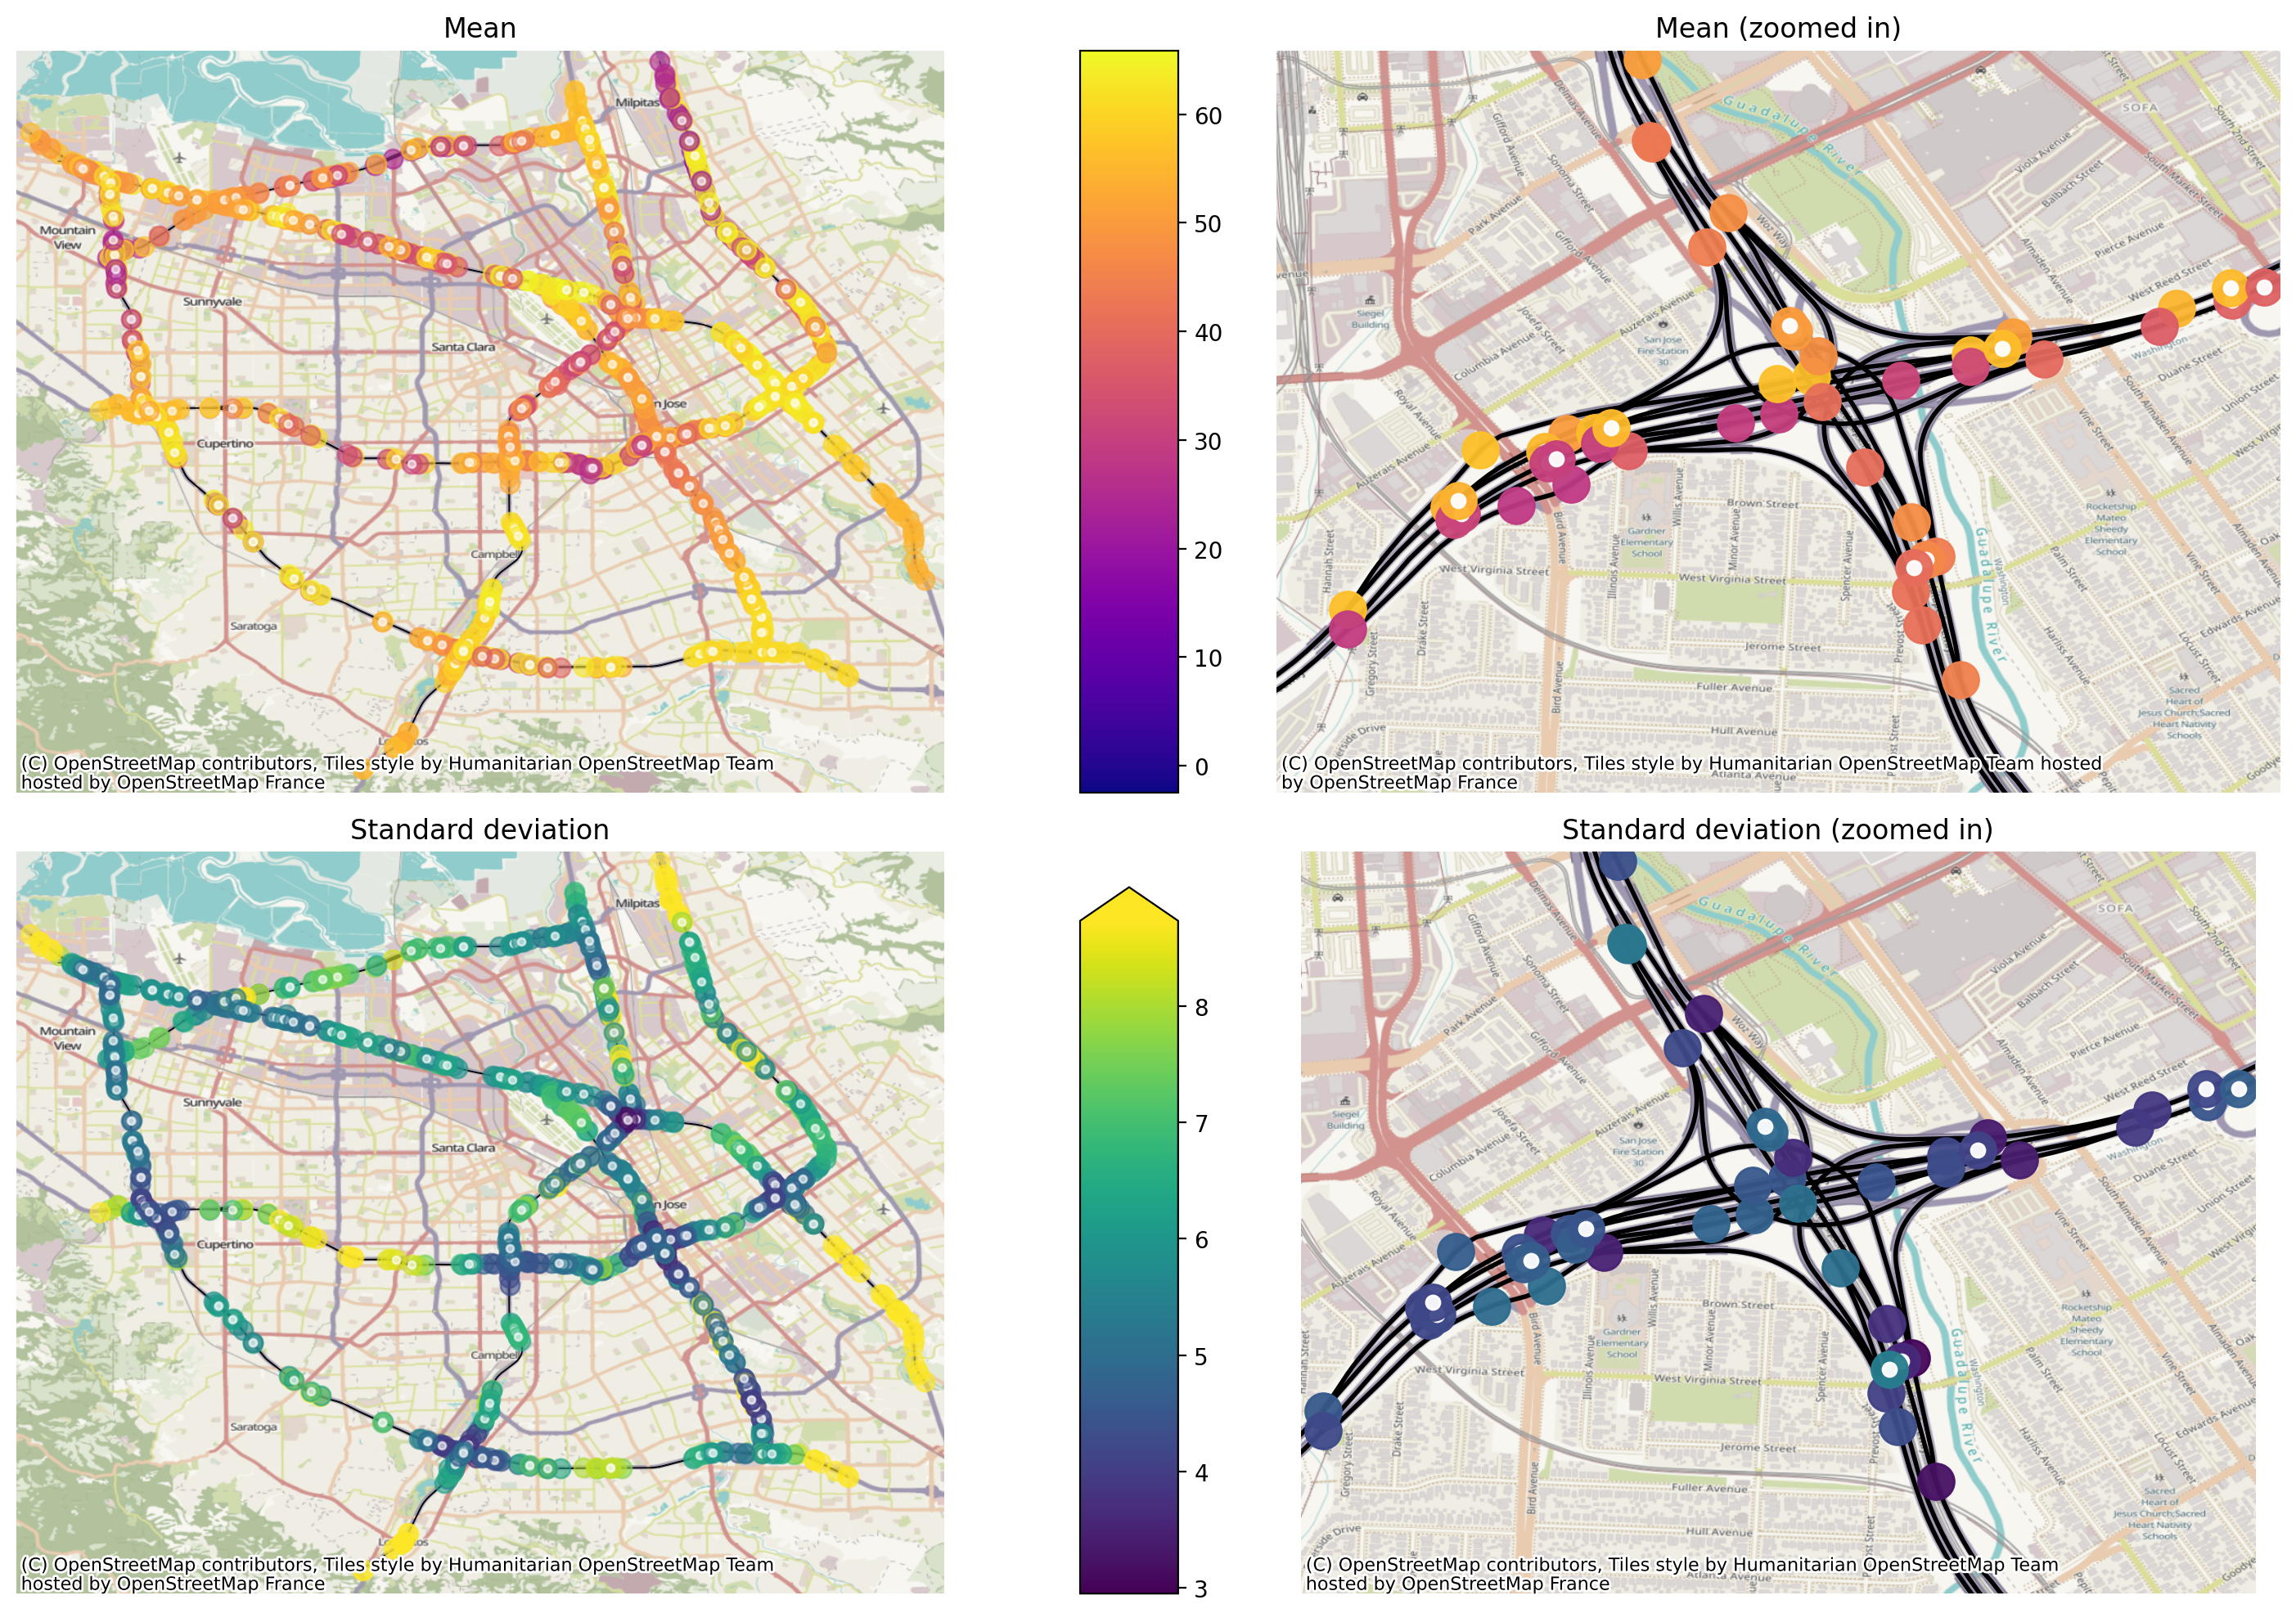

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

fig = plt.figure()
gs = fig.add_gridspec(2, 17, wspace=0.01, hspace=0.01)
ax11 = fig.add_subplot(gs[0,:8])
cax1 = fig.add_subplot(gs[0, 8])
ax12 = fig.add_subplot(gs[0, 9:])
ax21 = fig.add_subplot(gs[1,:8])
cax2 = fig.add_subplot(gs[1, 8])
ax22 = fig.add_subplot(gs[1, 9:])

fig.set_size_inches(15, 10)
plot_PEMS(G, mean.ravel(), all_verticies.ravel(), (orig_mean, orig_std), ax=ax11, fig=fig, cax=cax1,  vmin=vmin, vmax=vmax,
                    bbox=(37.450, 37.210, -121.80, -122.10), nodes_to_label=x_train.ravel(), node_size=70,
                    alpha=0.6, edge_linewidth=0.4, cmap_name='plasma',
                    plot_title='Mean')

plot_PEMS(G, mean.ravel(), all_verticies.ravel(), (orig_mean, orig_std), ax=ax12, fig=fig, cax=cax1, vmin=vmin, vmax=vmax,
                    bbox=(37.330741, 37.315718, -121.883005, -121.903327), nodes_to_label=x_train, node_size=250,
                    alpha=0.95, edge_linewidth=2, cmap_name='plasma',
                    plot_title='Mean (zoomed in)')

plot_PEMS(G, std.ravel(), all_verticies.ravel(), (0, orig_std), ax=ax21, fig=fig, cax=cax2,
          bbox=(37.450, 37.210, -121.80, -122.10),
          nodes_to_label=x_train, node_size=70  , alpha=0.6, edge_linewidth=0.4, cut_colormap=True,
                    plot_title='Standard deviation')

plot_PEMS(G, std.ravel(), all_verticies.ravel(), (0, orig_std), ax=ax22, fig=fig, cax=cax2,
          bbox=(37.330741, 37.315718, -121.883005, -121.902327),
          nodes_to_label=x_train, node_size=250, alpha=0.95, edge_linewidth=2, cut_colormap=True,
                    plot_title='Standard deviation (zoomed in)')
gs.tight_layout(fig)
plt.show()